In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [96]:
df = pd.read_csv('../csv/uk_house_prices/cluster_selection.csv')

In [97]:
df.head()

,seed,N,D,num_clusters,lengthscale_mult,lengthscale,kernel_var,noise_var,method,proj,ctr,feature_dist,rmse,test_kl,test_mnll,test_mean_mse,test_var_mse
0,0.0,10000.0,100.0,1722.0,0.125,0.248995,0.505562,0.201896,rff,gaussian,0.0,None,0.495316,1294.122803,0.725405,0.037602,0.000146
1,0.0,10000.0,100.0,1722.0,0.125,0.248995,0.505562,0.201896,maclaurin,rademacher,0.0,"[3, 5, 7, 10, 14, 23, 37]",0.478505,745.723511,0.685342,0.021491,0.000022
2,0.0,10000.0,100.0,1722.0,0.125,0.248995,0.505562,0.201896,maclaurin,rademacher,1.0,"[2, 4, 5, 6, 7, 10, 15]",0.475174,614.883301,0.676503,0.017836,0.000002
3,0.0,10000.0,100.0,1722.0,0.125,0.248995,0.505562,0.201896,maclaurin,srht,0.0,"[2, 5, 6, 10, 15, 23, 38]",0.472804,580.654114,0.671536,0.016719,0.000004
4,0.0,10000.0,100.0,1722.0,0.125,0.248995,0.505562,0.201896,maclaurin,srht,1.0,"[2, 4, 4, 6, 7, 11, 15]",0.481908,798.750061,0.692371,0.023125,0.000003


In [98]:
def get_error_over_input(config, error_field='test_kl', input_field='lengthscale_mult'):
    df_sel = df[(df['proj'] == config['proj']) & (df['method'] == config['method'])]
    df_sel = df_sel[(df_sel['ctr'] == config['ctr'])]
    df_sel = df_sel.groupby([input_field])
    
    cluster_means = df_sel['num_clusters'].mean().values
    error_means = df_sel['test_kl'].mean()
    error_stds = df_sel['test_kl'].std()
    
    return df_sel.groups.keys(), error_means, error_stds, cluster_means

In [99]:
configs = [
    ('RFF', {'method': 'rff', 'proj': 'gaussian', 'ctr': 0.0}),
    ('Macl. Radem.', {'method': 'maclaurin', 'proj': 'rademacher', 'ctr': 0.0}),
    ('Macl. CtR-Radem.', {'method': 'maclaurin', 'proj': 'rademacher', 'ctr': 1.0}),
    ('Macl. SRHT', {'method': 'maclaurin', 'proj': 'srht', 'ctr': 0.0}),
    ('Macl. CtR-SRHT', {'method': 'maclaurin', 'proj': 'srht', 'ctr': 1.0})
]

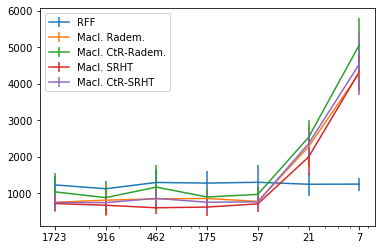

In [101]:
for config in configs:
    keys, means, stds, cluster_means = get_error_over_input(config[1])
    plt.errorbar(list(keys), means, yerr=stds, label=config[0])

plt.legend()
plt.xscale('log')
# plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
plt.xticks(list(keys), [int(mean) for mean in cluster_means])
plt.show()